# Spike Count Visualization

This tutorial demonstrates the way of visualizing the spike count of the last DynapCNN layer.

In [1]:
! pip install matplotlib

In [2]:
import copy
import random
import time
from multiprocessing import Process
from typing import Union

import matplotlib.pyplot as plt
import samna
import samnagui
import torch
from sinabs.from_torch import from_model
from sinabs.layers.pool2d import SumPool2d
from torch import nn

from sinabs.backend.dynapcnn import DynapcnnNetwork

## 1. Create a 1-layer CNN which can be deployed to the devkit

In [3]:
# init a cnn it has 2 out_channels for a binary classification task
# the input shape of this cnn is (1, 16, 16), output shape of this cnn is (2, 1, 1)

input_shape = (1, 16, 16)

cnn = nn.Sequential(SumPool2d(kernel_size=(1, 1)),
                    nn.Conv2d(in_channels=1,
                              out_channels=2,
                              kernel_size=(16, 16),
                              stride=(1, 1),
                              padding=(0, 0),
                              bias=False),
                    nn.ReLU())

**assign the CNN layer with a handcraft weight**:

The reason for designing the weights in this way is:

1. We will create a bunch of fake input spikes $X[x_0, x_1, ...x_{T}]$ as the input of the devkit.
2. for any input spike $x_{t}$ with timestamp $t$:

- if $t$, if $t < 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [0, 7], i.e. on the top-half of the input region.
- if $t$, if $t > 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [8, 15].i.e. on the bottom-half of the input region.

3. Based on this
- the output spike from time $0$ to $0.5 * T$ will all come from output channel #0
- the output spike from time $0.5 * T$ to $T$ will all come from output channel #1

![handcraft_weights](../../_static/using_readout_layer/handcraft_weights.png)

In [4]:
# set handcraft weights for the CNN
weight_ones = torch.ones(1, 8, 16, dtype=torch.float32)
weight_zeros = torch.zeros(1, 8, 16, dtype=torch.float32)

channel_1_weight = torch.cat([weight_ones, weight_zeros], dim=1).unsqueeze(0)
channel_2_weight = torch.cat([weight_zeros, weight_ones], dim=1).unsqueeze(0)
handcraft_weight = torch.cat([channel_1_weight, channel_2_weight], dim=0)

output_cnn_lyr_id = 1
cnn[output_cnn_lyr_id].weight.data = handcraft_weight

Then we convert the CNN into SNN and trying to deploy it to the devkit

In [5]:
# cnn to snn
snn = from_model(cnn, input_shape=input_shape, batch_size=1).spiking_model
# snn to DynapcnnNetwork
dynapcnn_net = DynapcnnNetwork(snn=snn, input_shape=input_shape, dvs_input=False)

## 2. Prepare for deployment

To deploy the SNN to the devkit, there are usually 3 parts you need to set up:

1. **Devkit configuration**. It is an instance of the `samna.speckxx.configuration` class. It contains the configuration of the `CNN Layer`, `DVS Layer` and `Readout Layer`, those 3 parts of the devkit configuration are which we most care about.

2. **Samna graph**. It defines how the data flows into and out from the devkit, then we can obtain different type of data that we need from related nodes of the graph.

3. **Visualizer(optional)**. Samna provides a GUI visualizer for us to visualize: 1.the input signal of the devkit. 2.the output of the devkit. 3.the real-time power consumption of the devkit.

In this experiment, the samna graph is defined as below:

![samna graph](../../_static/visualize_spike_count/samna_graph.png)

Then we can:

1. visualize the input of devkit through GUI window.
2. visualize the spike count of the last DynapCNN layer through GUI window.
3. Get data from last DynapCNN layer.

### Notice

**Make sure your devkit is plugged in your PC when running the experiment codes below**

### 2.1 Create devkit configuration

In [6]:
# init devkit config
devkit_cfg = dynapcnn_net.make_config(device="speck2edevkit:0")

# ========== modify devkit config ==========

"""cnn layers configuration"""
# send to output spike from cnn output layer to readout layer as its input
cnn_output_layer = dynapcnn_net.chip_layers_ordering[-1]
devkit_cfg.cnn_layers[cnn_output_layer].monitor_enable = True


"""dvs layer configuration"""
# link the dvs layer to the 1st layer of the cnn layers
devkit_cfg.dvs_layer.destinations[0].enable = True
devkit_cfg.dvs_layer.destinations[0].layer = dynapcnn_net.chip_layers_ordering[0]
# merge the polarity of input events
devkit_cfg.dvs_layer.merge = True
# drop the raw input events from the dvs sensor, since we write events to devkit manually
devkit_cfg.dvs_layer.pass_sensor_events = False
# enable monitoring the output from dvs pre-preprocessing layer
devkit_cfg.dvs_layer.monitor_enable = True

Network is valid


### 2.2 Construct samna graph

In [7]:
# open devkit
device_names = [each.device_type_name for each in samna.device.get_all_devices()]
print(f"Open device: {device_names[0]}")
devkit = samna.device.open_device(device_names[0])

Open device: Speck2eDevKit


In [8]:
# init the graph
samna_graph = samna.graph.EventFilterGraph()


# init necessary nodes in samna graph
# node for writing fake inputs into devkit
input_buffer_node = samna.BasicSourceNode_speck2e_event_speck2e_input_event()
# node for reading Spike(i.e. the output from last CNN layer)
spike_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()


# build input branch for graph
samna_graph.sequential([input_buffer_node, devkit.get_model_sink_node()])

# build output branches for graph
# branch #1: for the dvs input visualization
_, _, streamer = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eDvsToVizConverter", "VizEventStreamer"])
# branch #2: for the spike count plot (first divide spike events into groups by class, then count spike events per class)
_, spike_collection_filter, spike_count_filter, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eSpikeCollectionNode", "Speck2eSpikeCountNode", streamer])
# branch #3: for obtaining the output Spike from cnn output layer
_, type_filter_node_spike, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eOutputEventTypeFilter", spike_buffer_node])


# set the streamer nodes of the graph
# tcp communication port for dvs input data visualization
streamer_endpoint = 'tcp://0.0.0.0:40009'  
streamer.set_streamer_endpoint(streamer_endpoint)
# add desired type for filter node
type_filter_node_spike.set_desired_type("speck2e::event::Spike")
# add configurations for spike collection and counting filters
time_interval = 50
labels = ["0", "1"]  # a list that contains the names of output classes
num_of_classes = len(labels)
spike_collection_filter.set_interval_milli_sec(time_interval)  # divide according to this time period in milliseconds.
spike_count_filter.set_feature_count(num_of_classes)  # number of output classes


# start samna graph before using the devkit
samna_graph.start()

True

### 2.3 Set up visualizer

In [9]:
# init samna node for tcp transmission
samna_node = samna.init_samna()
sender_endpoint = samna_node.get_sender_endpoint()
receiver_endpoint = samna_node.get_receiver_endpoint()
visualizer_id = 3
time.sleep(1)  # wait tcp connection build up, this is necessary to open remote node.

sender_endpoint: tcp://0.0.0.0:47907
receiver_endpoint: tcp://0.0.0.0:33551


In [10]:
# define a function that run the GUI visualizer in the sub-process
def run_visualizer(receiver_endpoint, sender_endpoint, visualizer_id):

    samnagui.runVisualizer(0.6, 0.6, receiver_endpoint, sender_endpoint, visualizer_id)

    return

In [11]:
# create the subprocess
gui_process = Process(target=run_visualizer, args=(receiver_endpoint, sender_endpoint, visualizer_id))
gui_process.start()
print("GUI process started, you should see a window pop up!")

# wait for open visualizer and connect to it.
timeout = 10
begin = time.time()
name = "visualizer" + str(visualizer_id)
while time.time() - begin < timeout:

    try:

        time.sleep(0.05)
        samna.open_remote_node(visualizer_id, name)

    except:

        continue

    else:

        visualizer = getattr(samna, name)
        print(f"successful connect the GUI visualizer!")
        break

GUI process started, you should see a window pop up!
successful connect the GUI visualizer!


In [12]:
# set up the visualizer and GUI layout

# set visualizer's receiver endpoint to streamer's sender endpoint for tcp communication
visualizer.receiver.set_receiver_endpoint(streamer_endpoint)
# connect the receiver output to splitter inside the visualizer
visualizer.receiver.add_destination(visualizer.splitter.get_input_channel())

# add plots to gui
activity_plot_id = visualizer.plots.add_activity_plot(128, 128, "DVS Layer")
plot = visualizer.plot_0
plot.set_layout(0, 0, 0.5, 1.0)

# add spike count plot to gui
spike_count_id = visualizer.plots.add_spike_count_plot("Spike Count", num_of_classes, labels)
plot = visualizer.plot_1
plot.set_layout(0.5, 0.5, 1, 1)
plot.set_show_x_span(10)  # set the range of x axis
plot.set_label_interval(1.0)  # set the x axis label interval
plot.set_max_y_rate(1.2)  # set the y axis max value according to the max value of all actual values. 
plot.set_show_point_circle(True)  # if show a circle of every point.
plot.set_default_y_max(10)  # set the default y axis max value when all points value is zero.

visualizer.splitter.add_destination("dvs_event", visualizer.plots.get_plot_input(activity_plot_id))
visualizer.splitter.add_destination("spike_count", visualizer.plots.get_plot_input(spike_count_id))
visualizer.plots.report()

print("now you should see a change on the GUI window!")

now you should see a change on the GUI window!


## 3. Start Visualization

### 3.1 Create fake input for devkit

In [13]:
def create_fake_input_events(time_sec: int, data_rate: int = 1000):

    """
    Args:
        time_sec: how long is the input events
        data_rate: how many input events generated in 1 second

        During the first half time, it generates events where y coordinate only in range[0, 7] which means top half
        region of the input feature map.

        Then in the last half of time, it generates events where y coordinate only in range[8, 15] which means bottom
        half region of the input feature map.

    """

    time_offset_micro_sec = 5000  # make the timestamp start from 5000
    time_micro_sec = time_sec * 1000000  # timestamp unit is micro-second
    time_stride = 1000000 // data_rate

    half_time = time_micro_sec // 2

    events = []
    for time_stamp in range(time_offset_micro_sec, time_micro_sec + time_offset_micro_sec + 1, time_stride):

        spk = samna.speck2e.event.DvsEvent()
        spk.timestamp = time_stamp
        spk.p = random.randint(0, 1)
        spk.x = random.randint(0, 15)

        if time_stamp < half_time:
            spk.y = random.randint(0, 7)  # spike located in top half of the input region
        else:
            spk.y = random.randint(8, 15)  # spike located in bottom half of the input region

        events.append(spk)

    return events

In [14]:
# create fake input events
input_time_length = 5 # seconds
data_rate = 5000
input_events = create_fake_input_events(time_sec=input_time_length, data_rate=data_rate)

print(f"number of fake input spikes: {len(input_events)}")

number of fake input spikes: 25001


### 3.2 Write into the fake input and visualize the spike count of output

In [15]:
# apply the config to devkit
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

In [16]:
# write the fake input into the devkit

# enable & reset the stop-watch of devkit, this is mainly for the timestamp processing for the input&output events.
stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()
time.sleep(0.01)

# clear output buffer
spike_buffer_node.get_events()

# write through the input buffer node
input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
input_buffer_node.write(input_events)
# sleep till all input events is sent and processed
time.sleep(input_time_length + 0.02)

# get the output events from last DynapCNN Layer
dynapcnn_layer_events = spike_buffer_node.get_events()

print("You should see the input events through the GUI window as well as the spike count of output!")

You should see the input events through the GUI window as well as the spike count of output!


The visualization of spike count is just like:

![spike count visualization](../../_static/visualize_spike_count/spike_count.png)

### 3.3 Check the output from DynapCNN Layer

number of fake input spikes: 25001
number of output spikes from DynacpCNN Layer: 25001


Text(0.5, 1.0, 'OutputSpike')

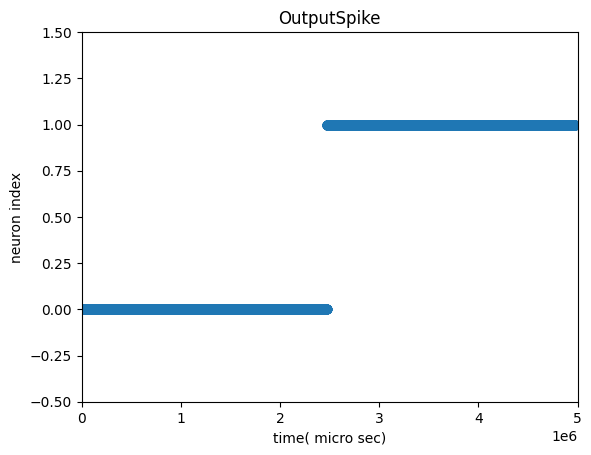

In [17]:
print(f"number of fake input spikes: {len(input_events)}")
print(f"number of output spikes from DynacpCNN Layer: {len(dynapcnn_layer_events)}")

# get the timestamp of the output event
spike_timestamp = [each.timestamp for each in dynapcnn_layer_events]
# shift timestep starting from 0
start_t = spike_timestamp[0]
spike_timestamp = [each - start_t for each in spike_timestamp]

# get the neuron index of each output spike 
neuron_id = [each.feature  for each in dynapcnn_layer_events]


# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(spike_timestamp, neuron_id)
ax.set(xlim=(0, input_time_length * 1e6),ylim=(-0.5, 1.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("OutputSpike")

In [18]:
# stop devkit when experiment finished.

gui_process.terminate()
gui_process.join()

samna_graph.stop()
samna.device.close_device(devkit)